In [6]:
pip install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install torchsummaryX
!pip install pandas
!pip install sklearn
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package 

In [8]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


# Get Data

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummaryX import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import os
import time
import datetime

In [10]:
# URL of the CSV file containing the list of stock tickers
# from: https://datahub.io/core/nyse-other-listings 

url = 'https://pkgstore.datahub.io/core/nyse-other-listings/nyse-listed_csv/data/3c88fab8ec158c3cd55145243fe5fcdf/nyse-listed_csv.csv'

# Read the CSV file into a DataFrame
stock_tickers_df = pd.read_csv(url)

stock_tickers_df.head()

,ACT Symbol,Company Name
0,A,"Agilent Technologies, Inc. Common Stock"
1,AA,Alcoa Inc. Common Stock
2,AA$B,Alcoa Inc. Depository Shares Representing 1/10...
3,AAC,"AAC Holdings, Inc. Common Stock"
4,AAN,"Aaron's, Inc. Common Stock"


In [11]:
# Check if stock_data.csv exists and make boolean variable

file_exists = os.path.isfile('data/stock_data.csv')
if file_exists:
    print('stock_data.csv exists')

stock_data.csv exists


In [12]:
!pip install yfinance


Defaulting to user installation because normal site-packages is not writeable


In [13]:
# Download gamestop stock data using yfinance
import yfinance as yf
import pandas as pd

if not file_exists:

    # Get the list of top 1000 companies or your desired list of symbols
    # Here, we are using a sample list of symbols for demonstration purposes.
    # You may want to replace it with the actual symbols you are interested in.
    symbols = stock_tickers_df['ACT Symbol'].tolist()

    # Define the date range
    start_date = "2020-01-01"
    end_date = "2021-12-30"

    # Create an empty DataFrame to store the data
    df = pd.DataFrame()

    # Loop through each symbol and fetch the data
    for symbol in symbols:
        stock_data = yf.download(symbol, start=start_date, end=end_date)
        
        # Extract only the "Close" and "Volume" columns
        stock_data = stock_data[["Close", "Volume"]]
        
        # Rename columns with the symbol for clarity
        stock_data.columns = [f"{symbol}_Close", f"{symbol}_Volume"]
        
        # Merge the data into the main DataFrame
        df = pd.concat([df, stock_data], axis=1)

    # Print the resulting DataFrame
    print(df.head())

/Users/hatu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
# Drop any column that has nan values
if not file_exists:
    df = df.dropna(axis=1)

    print(f"Shape: {df.shape}")

    # Get max and min time
    max_time = df.index.max()
    min_time = df.index.min()
    print(f"Max time: {max_time}, Min time: {min_time}")

In [15]:
# Save the data to a CSV file
if not file_exists:
    df.to_csv("data/stock_data.csv")

In [16]:
# Load stock data
df = pd.read_csv("data/stock_data.csv", index_col=0, parse_dates=True)

# Create df of stock data in terms of pct change
df_pct_change = df.pct_change()
df_pct_change.head()

# Save pct change df
df_pct_change.to_csv("data/stock_data_pct_change.csv")

# 1. Model Building
## Time Series Forecasting

In [17]:
# Read in percent change data
data_pct_change = pd.read_csv('data/stock_data_pct_change.csv')

# Read in levels data
data = pd.read_csv('data/stock_data.csv')

# drop rows where all values are nan besides date
data_pct_change = data_pct_change.dropna(how='all', subset=data_pct_change.columns[1:])
data = data.dropna(how='all', subset=data.columns[1:])


# Set start date and end date
start_date = '2020-06-01'
end_date = '2021-08-31'

# Subset data to only include dates between start and end date
data_pct_change = data_pct_change[(data_pct_change['Date'] >= start_date) & (data_pct_change['Date'] <= end_date)]
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]


print(f"Shape of data: {data_pct_change.shape}")
data_pct_change.head()

Shape of data: (317, 3037)


,Date,A_Close,A_Volume,AA_Close,AA_Volume,AAP_Close,AAP_Volume,AAT_Close,AAT_Volume,AB_Close,...,YPF_Close,YPF_Volume,YUM_Close,YUM_Volume,ZF_Close,ZF_Volume,ZTR_Close,ZTR_Volume,ZTS_Close,ZTS_Volume
103,2020-06-01,0.020082,0.034705,0.030402,-0.303473,0.003373,-0.364948,0.016049,-0.445626,0.023228,...,0.009921,-0.529350,0.008804,-0.862143,0.016766,-0.058222,0.016767,-0.057655,-0.007533,-0.497957
104,2020-06-02,0.004226,-0.320794,0.045311,0.134276,-0.002146,-0.357551,0.014667,0.376844,0.017613,...,0.066798,0.148831,0.018670,0.233256,0.025913,0.422508,0.025913,0.422842,0.022698,0.167091
105,2020-06-03,0.002215,-0.178453,0.085686,0.367251,0.020288,-0.038867,0.090437,0.825121,0.012692,...,0.053407,-0.004881,0.025485,0.073755,0.026406,-0.097586,0.026406,-0.097468,0.007421,-0.114972
106,2020-06-04,0.007183,0.611212,0.080780,0.333995,-0.000843,-0.040246,0.057444,-0.204696,-0.001899,...,0.010490,-0.176184,0.004547,-0.048780,-0.005593,-0.440239,-0.005592,-0.440974,-0.014102,0.044741
107,2020-06-05,-0.008339,0.277082,0.036941,0.634000,0.027426,0.864567,0.055288,-0.148708,0.000761,...,-0.006920,0.117074,0.016107,0.467402,0.021372,0.405529,0.021372,0.407197,0.003487,0.277413


In [18]:
# Create column "GME_close_day_ahead" which is the close price of GME one day ahead
data_pct_change['GME_close_day_ahead'] = data_pct_change['GME_Close'].shift(-1)

# Move columns 'GME_close_day_ahead', 'GME_Close' and 'GME_Volume' to the front of the dataframe
cols = list(data_pct_change.columns) ; cols.remove('GME_close_day_ahead');cols.remove('GME_Close');cols.remove('GME_Volume'); cols.remove('Date')
cols = ['Date', 'GME_close_day_ahead', 'GME_Close', 'GME_Volume'] + cols
data_pct_change = data_pct_change[cols]

data_pct_change.head()

,Date,GME_close_day_ahead,GME_Close,GME_Volume,A_Close,A_Volume,AA_Close,AA_Volume,AAP_Close,AAP_Volume,...,YPF_Close,YPF_Volume,YUM_Close,YUM_Volume,ZF_Close,ZF_Volume,ZTR_Close,ZTR_Volume,ZTS_Close,ZTS_Volume
103,2020-06-01,0.012106,0.017241,-0.340788,0.020082,0.034705,0.030402,-0.303473,0.003373,-0.364948,...,0.009921,-0.529350,0.008804,-0.862143,0.016766,-0.058222,0.016767,-0.057655,-0.007533,-0.497957
104,2020-06-02,0.062201,0.012106,-0.092740,0.004226,-0.320794,0.045311,0.134276,-0.002146,-0.357551,...,0.066798,0.148831,0.018670,0.233256,0.025913,0.422508,0.025913,0.422842,0.022698,0.167091
105,2020-06-03,0.006757,0.062201,0.281928,0.002215,-0.178453,0.085686,0.367251,0.020288,-0.038867,...,0.053407,-0.004881,0.025485,0.073755,0.026406,-0.097586,0.026406,-0.097468,0.007421,-0.114972
106,2020-06-04,-0.073825,0.006757,0.157009,0.007183,0.611212,0.080780,0.333995,-0.000843,-0.040246,...,0.010490,-0.176184,0.004547,-0.048780,-0.005593,-0.440239,-0.005592,-0.440974,-0.014102,0.044741
107,2020-06-05,0.210145,-0.073825,0.785391,-0.008339,0.277082,0.036941,0.634000,0.027426,0.864567,...,-0.006920,0.117074,0.016107,0.467402,0.021372,0.405529,0.021372,0.407197,0.003487,0.277413


In [19]:
# Find 10 columns that correlate most with GME_close_day_ahead
correlation = data_pct_change.drop('Date', axis=1).corr()

# Subset just 'GME_close_day_ahead' column
correlation = correlation['GME_close_day_ahead']

# Turn correlation into df, making index a column also
correlation = correlation.reset_index()

# Rename index to 'column', and 'GME_close_day_ahead' to 'correlation'
correlation = correlation.rename(columns={'index':'column', 'GME_close_day_ahead':'correlation'})

# Create absolute value of correlation as new column
correlation['abs_correlation'] = abs(correlation['correlation'])

# Sort by absolute value of correlation
correlation = correlation.sort_values(by='abs_correlation', ascending=False)

# Extract ticker from column, text before first underscore
correlation['ticker'] = correlation['column'].apply(lambda x: x.split('_')[0])


correlation.head(30)

,column,correlation,abs_correlation,ticker
0,GME_close_day_ahead,1.000000,1.000000,GME
2132,PBH_Volume,0.367330,0.367330,PBH
2133,PBI_Close,0.317414,0.317414,PBI
2134,PBI_Volume,0.245946,0.245946,PBI
1746,MITT_Volume,0.242633,0.242633,MITT
342,BGS_Volume,0.207390,0.207390,BGS
2296,PYS_Volume,0.207245,0.207245,PYS
1182,GJT_Volume,-0.195923,0.195923,GJT
1839,MTR_Close,0.195681,0.195681,MTR
2725,TRI_Close,0.187320,0.187320,TRI


In [20]:
url = 'https://pkgstore.datahub.io/core/nyse-other-listings/nyse-listed_csv/data/3c88fab8ec158c3cd55145243fe5fcdf/nyse-listed_csv.csv'
stock_tickers_df = pd.read_csv(url)

# rename 'ACT Symbol' to 'ticker'
stock_tickers_df = stock_tickers_df.rename(columns={'ACT Symbol':'ticker'})

# Merge correlation dataframe with stock_tickers_df to get company names
correlation = correlation.merge(stock_tickers_df, on='ticker', how='left')
correlation.head(30)

,column,correlation,abs_correlation,ticker,Company Name
0,GME_close_day_ahead,1.000000,1.000000,GME,Gamestop Corporation Common Stock
1,PBH_Volume,0.367330,0.367330,PBH,"Prestige Brand Holdings, Inc. Common Stock"
2,PBI_Close,0.317414,0.317414,PBI,Pitney Bowes Inc. Common Stock
3,PBI_Volume,0.245946,0.245946,PBI,Pitney Bowes Inc. Common Stock
4,MITT_Volume,0.242633,0.242633,MITT,"AG Mortgage Investment Trust, Inc. Common Stock"
5,BGS_Volume,0.207390,0.207390,BGS,"B&G Foods, Inc. B&G Foods, Inc. Common Stock"
6,PYS_Volume,0.207245,0.207245,PYS,Merrill Lynch Depositor Inc PPlus Tr Ser RRD
7,GJT_Volume,-0.195923,0.195923,GJT,Synthetic Fixed
8,MTR_Close,0.195681,0.195681,MTR,Mesa Royalty Trust Common Stock
9,TRI_Close,0.187320,0.187320,TRI,Thomson Reuters Corp Ordinary Shares


In [21]:
# Subset the levels data to only include the top 20 correlated columns, with GME_close at front
num_columns = 20
top_20_columns = correlation['column'].head(num_columns).tolist()
top_20_columns.remove('GME_close_day_ahead')
top_20_columns = ['Date', 'GME_Close', 'GME_Volume'] + top_20_columns 
data_subset = data[top_20_columns]

#Print column names
print(f"Columns in data: {data_subset.columns}")

print(f"Shape of data: {data_subset.shape}")
data_subset.head()

Columns in data: Index(['Date', 'GME_Close', 'GME_Volume', 'PBH_Volume', 'PBI_Close',
       'PBI_Volume', 'MITT_Volume', 'BGS_Volume', 'PYS_Volume', 'GJT_Volume',
       'MTR_Close', 'TRI_Close', 'MBI_Close', 'GJS_Volume', 'LEE_Volume',
       'WLKP_Volume', 'HPP_Volume', 'NOK_Close', 'POST_Close', 'PII_Close',
       'GDOT_Close', 'BTA_Close'],
      dtype='object')
Shape of data: (317, 22)


,Date,GME_Close,GME_Volume,PBH_Volume,PBI_Close,PBI_Volume,MITT_Volume,BGS_Volume,PYS_Volume,GJT_Volume,...,MBI_Close,GJS_Volume,LEE_Volume,WLKP_Volume,HPP_Volume,NOK_Close,POST_Close,PII_Close,GDOT_Close,BTA_Close
103,2020-06-01,1.0325,10446400,523900,2.448416,2160500,968867,1082700,726,1100,...,7.05,1200,14150,80600,2692600,4.20,57.846859,85.323219,38.220001,10.506813
104,2020-06-02,1.0450,9477600,532400,2.344026,3323300,787067,699900,1116,700,...,7.22,1300,27180,76500,3160200,4.31,57.807590,85.304115,38.119999,10.561966
105,2020-06-03,1.1100,12149600,437700,2.476885,5090800,1028233,2087600,1297,8600,...,7.44,2300,21180,97200,5953400,4.37,58.854713,88.353416,38.759998,10.571160
106,2020-06-04,1.1175,14057200,339100,2.552805,2665400,1993267,1936000,734,500,...,7.49,700,44340,36900,4276000,4.28,57.787956,92.193207,39.139999,10.607929
107,2020-06-05,1.0350,25097600,493700,2.752095,2434300,4457633,1701200,2372,1400,...,7.51,0,83130,37100,2685500,4.46,59.528797,93.261421,39.959999,10.580354


# LSTM data engineering

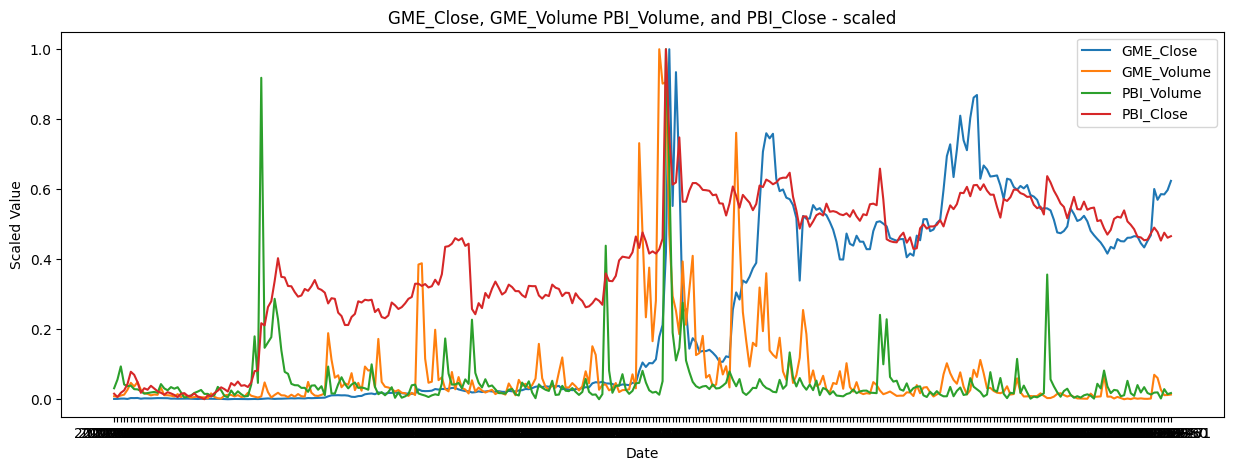

In [91]:
data_transformed = data_subset.copy()
data_transformed = data_transformed.set_index('Date')

scalars = {}
for column in data_transformed.columns:
    scalar = MinMaxScaler()
    data_transformed[column] = scalar.fit_transform(data_transformed[column].values.reshape(-1,1))
    scalars[column] = scalar

data_transformed = data_transformed.reset_index()

# Plot transformed GME_Close, GME_Volume and AMC_Close
plt.figure(figsize=(15, 5))
plt.plot(data_transformed['Date'], data_transformed['GME_Close'], label='GME_Close')
plt.plot(data_transformed['Date'], data_transformed['GME_Volume'], label='GME_Volume')
plt.plot(data_transformed['Date'], data_transformed['PBI_Volume'], label='PBI_Volume')
plt.plot(data_transformed['Date'], data_transformed['PBI_Close'], label='PBI_Close')
plt.title('GME_Close, GME_Volume PBI_Volume, and PBI_Close - scaled')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

In [23]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ",device)

Device:  mps


In [93]:
dates_test = ['2021-06-01',  '2021-08-31']

# Get rows indices where date is between dates in dates_test
test_indices = data_transformed[(data_transformed['Date'] >= dates_test[0]) & (data_transformed['Date'] <= dates_test[1])].index

# Count number of rows in test data by index
n_test_obs = len(test_indices)
print(f"Number of rows in test data: {n_test_obs}")

Number of rows in test data: 65


In [94]:
data_transf_vals = data_transformed.drop('Date', axis=1).values

# Convert DF to sequences of lags for LSTM

In [95]:
# Create input sequences and labels
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        label = data[i+seq_length:i+seq_length+1, 0]
        sequences.append((seq, label))
    return sequences

# Define sequence length
seq_length = 3  # Consider this many previous time steps for prediction

# Create sequences
sequences = create_sequences(data_transf_vals, seq_length)

# Convert to PyTorch tensors
inputs = torch.Tensor([seq for seq, _ in sequences])
labels = torch.Tensor([label for _, label in sequences]).unsqueeze(1)  # Unsqueeze to add a singleton dimension

print(f"Shape of inputs: {inputs.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of inputs: torch.Size([314, 3, 21])
Shape of labels: torch.Size([314, 1, 1])


## Train/Val/Test split

In [96]:
# Split into Train, Validation, and Test sets based on num of test obs
nseq = len(sequences)
test_start_index = nseq - n_test_obs

train_val_ratio = 0.8

test_indices = list(range(test_start_index, nseq ))

remaining_obs = list(range(test_start_index))
n_train = int(train_val_ratio * len(remaining_obs))
train_indices = remaining_obs[:n_train]
val_indices = remaining_obs[n_train:]

print(f"Start/End train indices: {train_indices[0]}/{train_indices[-1]}")
print(f"Start/End val indices: {val_indices[0]}/{val_indices[-1]}")
print(f"Start/End test indices: {test_indices[0]}/{test_indices[-1]}")
print(f"Out of a total of {nseq} sequences")

Start/End train indices: 0/198
Start/End val indices: 199/248
Start/End test indices: 249/313
Out of a total of 314 sequences


In [97]:
# the correct shape (batch_size, sequence_length, input_size)

# Create dataset for each set 
train_dataset = TensorDataset(inputs[train_indices], labels[train_indices])
val_dataset = TensorDataset(inputs[val_indices], labels[val_indices])
test_dataset = TensorDataset(inputs[test_indices], labels[test_indices])
entire_dataset = TensorDataset(inputs, labels)

# Create DataLoader for each set, setting pin=True and num_workers = 2
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
entire_loader = DataLoader(entire_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

In [98]:
for i, data in enumerate(train_loader):
    data, label = data
    print(data.shape, label.shape)
    break

torch.Size([4, 3, 21]) torch.Size([4, 1, 1])


## Define Pytorch Training Functions

In [99]:
from tqdm import tqdm

def train(model, dataloader, optimizer, criterion, device):

    model.train()
    tloss = 0.0  # Monitoring loss
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (sequences, labels) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()
        ### Move Data to Device (Ideally GPU)
        sequences = sequences.to(device)
        labels = labels.to(device)
        ### Forward Propagation
        outputs = model(sequences)
        ### Loss Calculation
        loss = criterion(outputs, labels)
        ### Backward Propagation
        loss.backward()
        ### Gradient Descent
        optimizer.step()
        tloss += loss.item()
        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))) )
        batch_bar.update()

        ### Release memory
        del sequences, labels, outputs
        # torch.cuda.empty_cache()

    batch_bar.close()
    tloss /= len(dataloader)

    return tloss 

In [100]:
import torch.nn.functional as F

def eval(model, dataloader, criterion, device):

    model.eval()  # set model in evaluation mode
    vloss = 0  # Monitoring loss
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (sequences, labels) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        sequences = sequences.to(device)
        labels = labels.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.no_grad():
            ### Forward Propagation
            outputs = model(sequences)
            ### Loss Calculation
            loss = criterion(outputs, labels)

        vloss += loss.item()

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))))
        batch_bar.update()

        ### Release memory
        del sequences, labels, outputs
        # torch.cuda.empty_cache()

    batch_bar

    vloss /= len(dataloader)
    return vloss

## Define LSTM model

In [101]:
# Boilerplate LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # Keep the output at all time steps
        return out  # No need to extract a specific feature
    


# Model parameters
input_size = data_transf_vals.shape[1]  # Number of features
hidden_size = 100
num_layers = 1
output_size = 1

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Device:  mps


## Train Model

In [102]:
import wandb
w_and_b = False

# Example training loop (you'll need to adapt this based on your actual use case)

# Initialize train and val loss
train_losses = []
val_losses = []

num_epochs = 50
for epoch in range(num_epochs):

    if epoch  % 5 == 0:
        print("Epoch {}/{}".format(epoch + 1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])
    train_loss  = train(model, train_loader, optimizer, criterion, device)
    val_loss = eval(model, val_loader, criterion, device)

    if epoch  % 5 == 0:
        print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
        print("\tVal Loss {:.04f}".format(val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    ### Log metrics at each epoch in your run
    if w_and_b:
        wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'lr': curr_lr})

# Finish your wandb run
if w_and_b:
    wandb.finish()

Epoch 1/50


Train:   0%|          | 0/50 [00:00<?, ?it/s]/Users/hatu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Train:  96%|█████████▌| 48/50 [00:00<00:00, 43.28it/s, loss=0.0195]/Users/hatu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Val:  85%|████████▍ | 11/13 [00:00<00:01,  1.76it/s, loss=0.0420]  /Users/hatu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:608:

	Train Loss 0.0211	 Learning Rate 0.0010000
	Val Loss 0.0491


Epoch 6/50


	Train Loss 0.0096	 Learning Rate 0.0010000
	Val Loss 0.0197


Epoch 11/50


	Train Loss 0.0052	 Learning Rate 0.0010000
	Val Loss 0.0097


Epoch 16/50


	Train Loss 0.0054	 Learning Rate 0.0010000
	Val Loss 0.0116


Epoch 21/50


	Train Loss 0.0039	 Learning Rate 0.0010000
	Val Loss 0.0087


Epoch 26/50


	Train Loss 0.0035	 Learning Rate 0.0010000
	Val Loss 0.0101


Epoch 31/50


	Train Loss 0.0046	 Learning Rate 0.0010000
	Val Loss 0.0134


Epoch 36/50


	Train Loss 0.0034	 Learning Rate 0.0010000
	Val Loss 0.0101


Epoch 41/50


	Train Loss 0.0033	 Learning Rate 0.0010000
	Val Loss 0.0114


Epoch 46/50


	Train Loss 0.0045	 Learning Rate 0.0010000
	Val Loss 0.0169


## Plot Train/Val losses

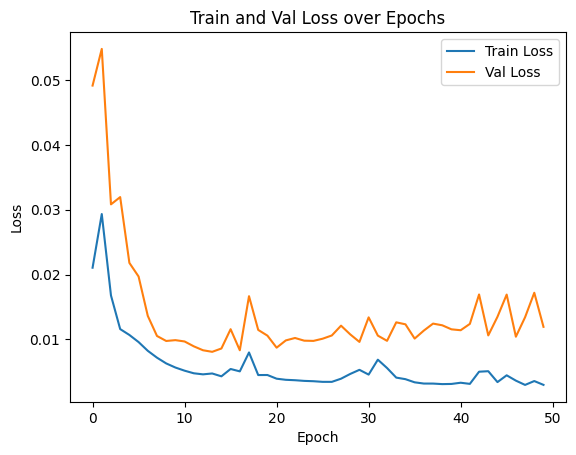

In [103]:
# Plot train and val losses over epochs
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss over Epochs')
plt.legend()
plt.show()

## Report MSE for test data

In [104]:
# Evaluate model on test data
test_loss = eval(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

# Save average of last 3 train/val losses and test loss to dict
losses = {'train_loss': np.mean(train_losses[-3:]), 'val_loss': np.mean(val_losses[-3:]), 'test_loss': test_loss}

Val:  88%|████████▊ | 15/17 [00:00<00:01,  1.34it/s, loss=0.0273]/Users/hatu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
                                                                 

Test Loss: 0.0310


## Plot true vs predicted values

In [105]:
# Get predictions on train and val data
model.eval()
predictions = []
actuals = []

pred_ts_train = np.array([])
actual_ts_train = np.array([])

for i, (sequences, labels) in enumerate(train_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(sequences)
        
        # concat the predictions and actuals
        pred_ts_train = np.concatenate([pred_ts_train, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts_train = np.concatenate([actual_ts_train, labels.cpu().numpy()[:, 0, 0].flatten() ])


pred_ts_val = np.array([])
actual_ts_val = np.array([])

for i, (sequences, labels) in enumerate(val_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(sequences)

        # concat the predictions and actuals
        pred_ts_val = np.concatenate([pred_ts_val, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts_val = np.concatenate([actual_ts_val, labels.cpu().numpy()[:, 0, 0].flatten() ])


# Get predictions on test data
model.eval()

pred_ts = np.array([])
actual_ts = np.array([])

for i, (sequences, labels) in enumerate(test_loader):  
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(sequences)
        
        # concat the predictions and actuals
        pred_ts = np.concatenate([pred_ts, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts = np.concatenate([actual_ts, labels.cpu().numpy()[:, 0, 0].flatten() ])

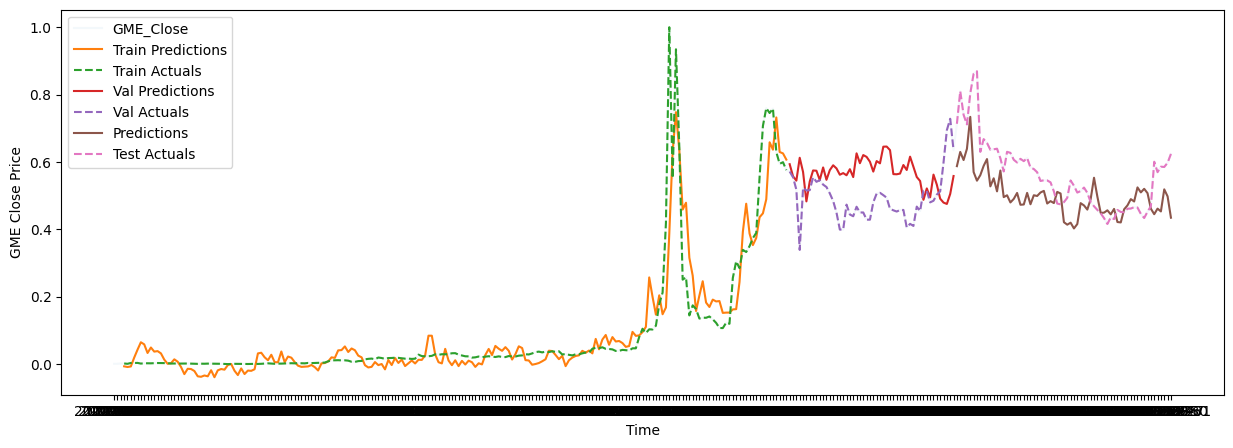

In [106]:
# plot the predictions and actuals

# Big fig size
plt.figure(figsize=(15, 5))

# get dates for train predictions
n_train_prediction = len(pred_ts_train)
dates_train = data_transformed['Date'][seq_length:n_train_prediction+seq_length]

# Get dates for val predictions
n_val_prediction = len(pred_ts_val)
dates_val = data_transformed['Date'][seq_length + n_train_prediction: n_train_prediction + n_val_prediction + seq_length]

# Get dates for the test predictions
n_prediction = len(pred_ts)
dates = data_transformed['Date'][-n_prediction:]



# Plot the GME_Close from the original data after transformation
plt.plot(data_transformed['Date'], data_transformed['GME_Close'] , label='GME_Close', alpha = .05)

# plot train and val predictions
plt.plot(dates_train, pred_ts_train, label='Train Predictions')
plt.plot(dates_train, actual_ts_train, label='Train Actuals', linestyle='dashed')

plt.plot(dates_val, pred_ts_val, label='Val Predictions')
plt.plot(dates_val, actual_ts_val, label='Val Actuals', linestyle='dashed')


plt.plot(dates, pred_ts, label='Predictions')
plt.plot(dates, actual_ts, label='Test Actuals', linestyle='dashed')


plt.xlabel('Time')
plt.ylabel('GME Close Price')

plt.legend()
plt.show()

# 2. Sentiment Analysis of Reddit Data

In [107]:
from textblob import TextBlob

# Read in reddit data
reddit_data = pd.read_csv('data/rGME_dataset_features.csv')

# Show all columns
pd.set_option('display.max_columns', None)

print(f"Shape of reddit data: {reddit_data.shape}")
reddit_data.head()

/var/folders/f4/m9cqwxnj7072nb0k6fn3x6wh0000gn/T/ipykernel_45211/578942155.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_data = pd.read_csv('data/rGME_dataset_features.csv')


Shape of reddit data: (1033236, 74)


,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,neg,neu,pos,spacy_title,clean_text,char_count,word_count,word_count_cln,stopword_count,pos_tags,dep_tags,_NOUN,_VERB,_ADP,_ADJ,_DET,_PROPN,_INTJ,_PUNCT,_NUM,_PRON,_ADV,_PART,_amod,_ROOT,_punct,_advmod,_auxpass,_nsubjpass,_ccomp,_acomp,_neg,_nsubj,_aux,_agent,_det,_pobj,_prep,_csubj,_nummod,_attr,_acl,_relcl,_dobj,_pcomp,_xcomp,_cc,_conj,_mark,_prt,_compound,_dep,_advcl,_parataxis,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,0.000,0.189,0.811,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,need GME 🚀 🚀 🚀 🚀 🚀 🚀,37,13,8,5,"{'VERB': 6, 'ADP': 1, 'PROPN': 6}","{'nsubj': 1, 'ROOT': 1, 'aux': 1, 'xcomp': 1, ...",0,6,1,0,0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,0.000,0.079,0.921,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,short squeeze incoming 🚀 🚀 🚀 🚀 🚀 🚀 🚀,30,10,10,0,"{'VERB': 6, 'NOUN': 4}","{'amod': 2, 'ROOT': 1, 'dobj': 4, 'appos': 3}",4,6,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,0.000,0.744,0.256,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,convinced 💰 GME EXTREME PUMP COMING,54,13,6,5,"{'VERB': 5, 'ADP': 3, 'PROPN': 5}","{'nsubj': 2, 'ROOT': 1, 'dobj': 1, 'prep': 2, ...",0,5,3,0,0,5,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,2,0,0,0,2,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,0.115,0.885,0.000,You already know what we must do brothers and ...,know brother sister submit complaint,95,21,5,13,"{'VERB': 17, 'NOUN': 4}","{'nsubj': 3, 'advmod': 1, 'ROOT': 3, 'dobj': 4...",4,17,0,0,0,0,0,0,0,0,0,0,0,3,3,1,0,0,1,0,0,3,2,0,1,0,0,0,0,0,0,0,4,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,0.000,1.000,0.000,ICR conference (11th Jan),ICR conference 11th Jan,25,6,4,0,"{'NOUN': 5, 'PROPN': 1}","{'compound': 1, 'ROOT': 1, 'punct': 2, 'amod':...",5,0,0,0,0,1,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


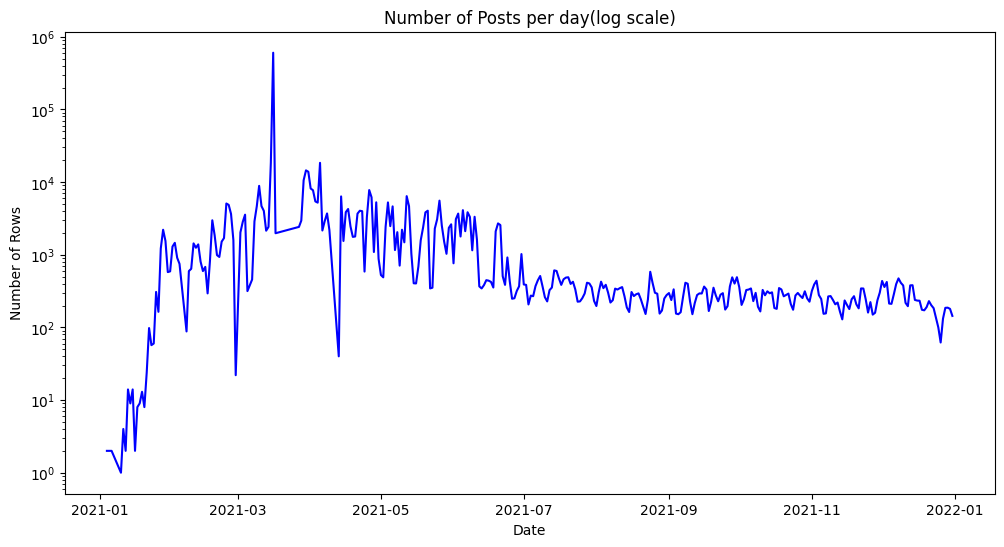

In [108]:
reddit_data['date'] = pd.to_datetime(reddit_data['date'])

daily_counts = reddit_data.groupby(reddit_data['date'].dt.date).size()

# plot the number of rows per day
plt.figure(figsize = (12,6))
daily_counts.plot(color='blue')
plt.title('Number of Posts per day(log scale)')
plt.xlabel('Date')
plt.yscale('log')
plt.ylabel('Number of Rows')
plt.show()

## Use textblob to get sentiment of each post, weight by the number of comments
### TextBlob is a Python library for processing textual data. It provides a simple API to perform common NLP tasks such as:

    **Sentiment analysis
    **Tokenization (splitting text into sentences or words)
    **Part-of-speech (POS) tagging
    **Noun phrase extraction
    **Language translation
    **Spelling correction

In [109]:
reddit_data = reddit_data[['date', 'title','num_comments']]

# use text blob to get sentimetn of each post
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# apply sentiment analysis to 'title' and create a new column 'sentiment'
reddit_data['sentiment'] = reddit_data['title'].apply(get_sentiment)

# calculate weighted sentiment socres using 'num_comments'
reddit_data['weighted_sentiment'] = reddit_data['sentiment'] * reddit_data['num_comments']

# aggregate sentiment scores for each day
daily_sentiment = reddit_data.groupby(reddit_data['date'].dt.date)['weighted_sentiment'].sum()/reddit_data.groupby(reddit_data['date'].dt.date)['num_comments'].sum()

# calculate the number of comments per day in log
daily_comments = np.log(reddit_data.groupby(reddit_data['date'].dt.date)['num_comments'].sum())

# merge together by date
daily_reddit = pd.concat([daily_sentiment, daily_comments], axis=1)

# rename columns
daily_reddit.columns = ['sentiment', 'log_comments']
daily_reddit.head()

/Users/hatu/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,sentiment,log_comments
date,,
2021-01-04,0.0000,2.302585
2021-01-05,-0.1950,2.302585
2021-01-06,0.1015,3.218876
2021-01-10,0.2600,2.772589
2021-01-11,0.0000,3.637586


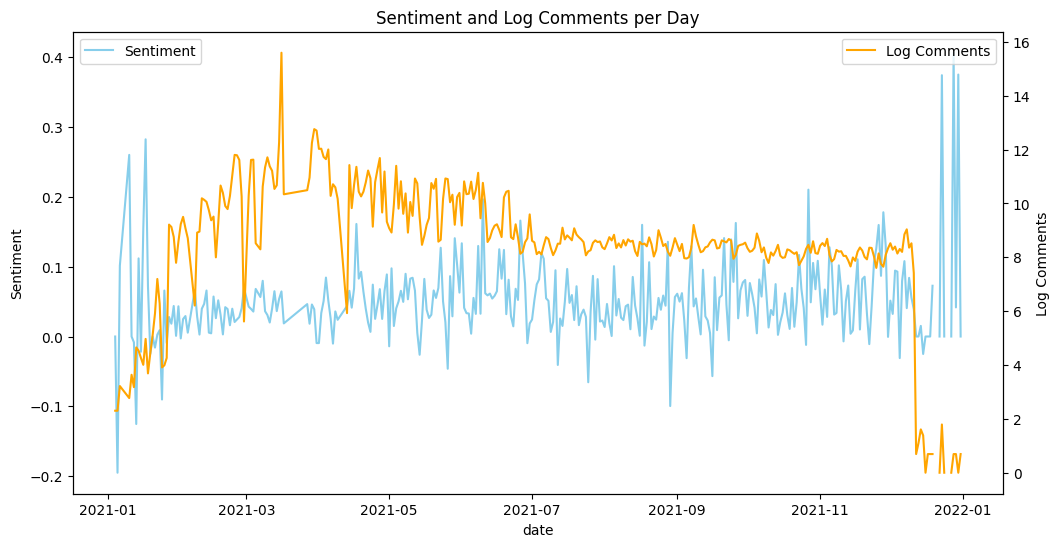

In [110]:
# plot 
# plt.gca() stands for "get current axes". It returns the current Axes object (ax1) for the figure. This is where you will plot the first dataset.
# ax1.twinx() creates a twin axes that shares the same x-axis but has a separate y-axis on the right side of the plot.

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()
daily_reddit['sentiment'].plot(ax=ax1, color='skyblue', label='Sentiment')
daily_reddit['log_comments'].plot(ax=ax2, color='orange', label='Log Comments')
ax1.set_ylabel('Sentiment')
ax2.set_ylabel('Log Comments')
plt.title('Sentiment and Log Comments per Day')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [111]:
data_transformed['Date'] = pd.to_datetime(data_transformed['Date'])
data_transformed = data_transformed.set_index('Date')

In [112]:
# merge daily_reddit with data_transformed
data_merged = data_transformed.merge(daily_reddit, left_index = True, right_index = True, how = 'left')

# fill missing values with 0
data_merged = data_merged.fillna(0)

# scale sentiment and log_commnets columns
scalar_sentiment = MinMaxScaler()
scalar_comments = MinMaxScaler()

data_merged['sentiment'] =  scalar_sentiment.fit_transform(data_merged['sentiment'].values.reshape(-1,1))
data_merged['log_comments'] =  scalar_sentiment.fit_transform(data_merged['log_comments'].values.reshape(-1,1))

data_merged.head()

,GME_Close,GME_Volume,PBH_Volume,PBI_Close,PBI_Volume,MITT_Volume,BGS_Volume,PYS_Volume,GJT_Volume,MTR_Close,TRI_Close,MBI_Close,GJS_Volume,LEE_Volume,WLKP_Volume,HPP_Volume,NOK_Close,POST_Close,PII_Close,GDOT_Close,BTA_Close,sentiment,log_comments
Date,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.000815,0.008492,0.042790,0.015697,0.031299,0.088340,0.047559,0.015035,0.035256,0.765715,0.030662,0.180628,0.144578,0.022094,0.119774,0.414115,0.283537,0.172089,0.004375,0.104852,0.000000,0.498051,0.0
2020-06-02,0.000960,0.007257,0.043642,0.006105,0.056100,0.070576,0.022722,0.023111,0.022436,0.709491,0.068328,0.202880,0.156627,0.046699,0.112973,0.498131,0.317073,0.170377,0.004048,0.101459,0.014736,0.498051,0.0
2020-06-03,0.001717,0.010662,0.034146,0.018314,0.093800,0.094141,0.112759,0.026860,0.275641,0.698782,0.079306,0.231675,0.277108,0.035369,0.147313,1.000000,0.335366,0.216039,0.056278,0.123176,0.017193,0.498051,0.0
2020-06-04,0.001804,0.013092,0.024258,0.025290,0.042068,0.188439,0.102923,0.015200,0.016026,0.856744,0.059811,0.238220,0.084337,0.079103,0.047279,0.698613,0.307927,0.169520,0.122047,0.136071,0.027017,0.498051,0.0
2020-06-05,0.000844,0.027159,0.039761,0.043604,0.037138,0.429243,0.087689,0.049122,0.044872,0.787134,0.081388,0.240838,0.000000,0.152353,0.047611,0.412840,0.362805,0.245434,0.140344,0.163895,0.019649,0.498051,0.0


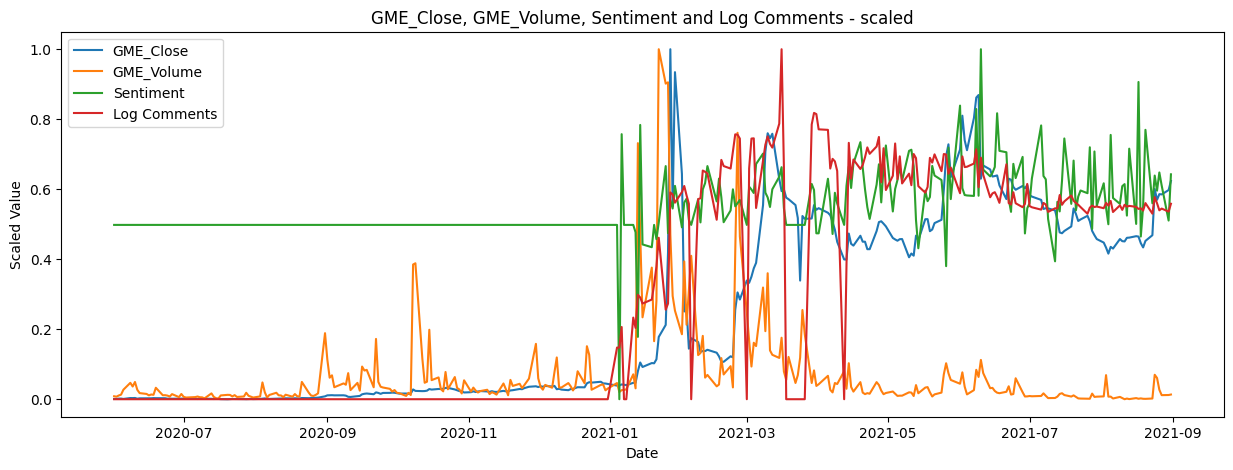

In [113]:
# Plot GME_Close, GME_Volume, Sentiment and Log Comments
plt.figure(figsize=(15, 5))
plt.plot(data_merged.index, data_merged['GME_Close'], label='GME_Close')
plt.plot(data_merged.index, data_merged['GME_Volume'], label='GME_Volume')
plt.plot(data_merged.index, data_merged['sentiment'], label='Sentiment')
plt.plot(data_merged.index, data_merged['log_comments'], label='Log Comments')
plt.title('GME_Close, GME_Volume, Sentiment and Log Comments - scaled')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

In [114]:
# Calculate correlation between GME_Close and sentiment
correlation = data_merged['GME_Close'].corr(data_merged['sentiment'])
print(f"Correlation between GME_Close and sentiment: {correlation:.4f}")

Correlation between GME_Close and sentiment: 0.5569


In [115]:
# Calculate correlation between GME_Close and log_comments
correlation = data_merged['GME_Close'].corr(data_merged['log_comments'])
print(f"Correlation between GME_Close and log_comments: {correlation:.4f}")

Correlation between GME_Close and log_comments: 0.8370


In [116]:
# Retrain LSTM with sentiment and log_comments
data_merged_vals = data_merged.values

# Create sequences
sequences_new = create_sequences(data_merged_vals, seq_length)


# convert to pytorch tensors
inputs = torch.Tensor([seq for seq, _ in sequences_new])
labels = torch.Tensor([label for _ , label in sequences_new]).unsqueeze(1)

print(f'Shape of inputs: {inputs.shape}')
print(f'Shape of labels: {labels.shape}')


Shape of inputs: torch.Size([314, 3, 23])
Shape of labels: torch.Size([314, 1, 1])


In [117]:
# Create dataset for each set 
train_dataset = TensorDataset(inputs[train_indices], labels[train_indices])
val_dataset = TensorDataset(inputs[val_indices], labels[val_indices])
test_dataset = TensorDataset(inputs[test_indices], labels[test_indices])
entire_dataset = TensorDataset(inputs, labels)

# Create DataLoader for each set, setting pin=True and num_workers = 2
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
entire_loader = DataLoader(entire_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

Device:  mps
Epoch 1/50


Train:   0%|          | 0/50 [00:00<?, ?it/s]/Users/hatu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Train:  96%|█████████▌| 48/50 [00:01<00:00, 49.39it/s, loss=0.0221]/Users/hatu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Val:  85%|████████▍ | 11/13 [00:00<00:01,  1.76it/s, loss=0.0594]  /Users/hatu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:608:

	Train Loss 0.0243	 Learning Rate 0.0010000
	Val Loss 0.0684


Epoch 6/50


	Train Loss 0.0248	 Learning Rate 0.0010000
	Val Loss 0.0956


Epoch 11/50


	Train Loss 0.0078	 Learning Rate 0.0010000
	Val Loss 0.0287


Epoch 16/50


	Train Loss 0.0048	 Learning Rate 0.0010000
	Val Loss 0.0188


Epoch 21/50


	Train Loss 0.0036	 Learning Rate 0.0010000
	Val Loss 0.0178


Epoch 26/50


	Train Loss 0.0053	 Learning Rate 0.0010000
	Val Loss 0.0166


Epoch 31/50


	Train Loss 0.0030	 Learning Rate 0.0010000
	Val Loss 0.0185


Epoch 36/50


	Train Loss 0.0062	 Learning Rate 0.0010000
	Val Loss 0.0148


Epoch 41/50


	Train Loss 0.0028	 Learning Rate 0.0010000
	Val Loss 0.0260


Epoch 46/50


	Train Loss 0.0024	 Learning Rate 0.0010000
	Val Loss 0.0233


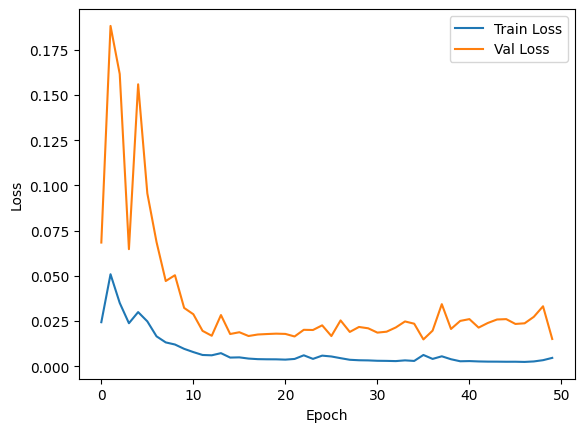

In [119]:
# new LSTM model

# set model parameters
input_size = data_merged_vals.shape[1] # Number of features
hidden_size = 100
number_layer = 3
output_size = 1

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ",device)

# Initialize the model
model_new = LSTMModel(input_size, hidden_size, number_layer, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_new.parameters(), lr=0.001)

w_and_b = False

train_losses = []
val_losses = []

num_epochs = 50

for epoch in range(num_epochs):

    if epoch % 5 == 0:
        print("Epoch {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])
    train_loss = train(model_new, train_loader, optimizer, criterion, device)
    val_loss = eval(model_new, val_loader, criterion, device)

    if epoch % 5 == 0:
        print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
        print("\tVal Loss {:.04f}".format(val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# plot train and val losses over epochs
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label = "Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [121]:
# Evaluate model on test data
test_loss = eval(model_new, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

# Save average of last 3 train/val losses and test loss to dict
losses_new = {'train_loss': np.mean(train_losses[-3:]), 'val_loss': np.mean(val_losses[-3:]), 'test_loss': test_loss}

Test Loss: 0.0469


In [128]:
# Get predictions on train and val data

model_new.eval()
predictions = []
actuals = []

pred_ts_train = np.array([])
actual_ts_train = np.array([])

for i, (sequences, labels) in enumerate(train_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_new(sequences)

        #concat the predictions and actuals
        pred_ts_train = np.concatenate([pred_ts_train, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts_train = np.concatenate([actual_ts_train, labels.cpu().numpy()[:, 0, 0].flatten() ])

pred_ts_val = np.array([])
actual_ts_val = np.array([])

for i, (sequences, labels) in enumerate(val_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_new(sequences)

        #concat the predictions and actuals
        pred_ts_val = np.concatenate([pred_ts_val, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts_val = np.concatenate([actual_ts_val, labels.cpu().numpy()[:, 0, 0].flatten() ])

pred_ts = np.array([])
actual_ts = np.array([])

for i, (sequences, labels) in enumerate(test_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_new(sequences)

        #concat the predictions and actuals
        pred_ts = np.concatenate([pred_ts, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts = np.concatenate([actual_ts, labels.cpu().numpy()[:, 0, 0].flatten() ])


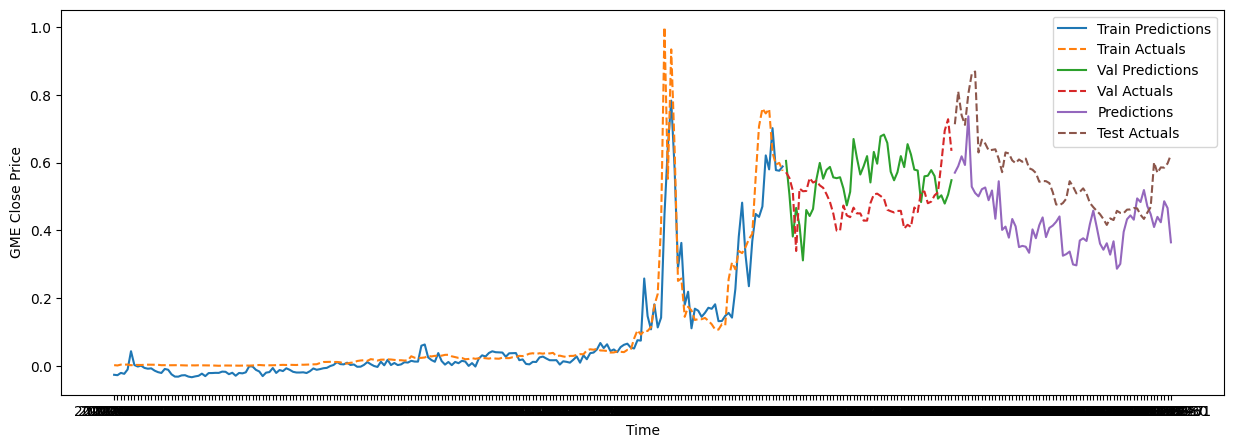

In [129]:
# plot the predictions and actuals

# Big fig size
plt.figure(figsize=(15, 5))

# plot train and val predictions
plt.plot(dates_train, pred_ts_train, label='Train Predictions')
plt.plot(dates_train, actual_ts_train, label='Train Actuals', linestyle='dashed')

plt.plot(dates_val, pred_ts_val, label='Val Predictions')
plt.plot(dates_val, actual_ts_val, label='Val Actuals', linestyle='dashed')


plt.plot(dates, pred_ts, label='Predictions')
plt.plot(dates, actual_ts, label='Test Actuals', linestyle='dashed')


plt.xlabel('Time')
plt.ylabel('GME Close Price')

plt.legend()
plt.show()

In [136]:
# Compare train/val/test losses for the two models
print("Old Model Losses without sentiment data:")
for k, v in losses.items():
    print(f"{k}: {v:.4f}")

print("\nNew Model Losses WITH sentiment data:")
for k, v in losses_new.items():
    print(f"{k}: {v:.4f}")

Old Model Losses without sentiment data:
train_loss: 0.0032
val_loss: 0.0142
test_loss: 0.0310

New Model Losses WITH sentiment data:
train_loss: 0.0035
val_loss: 0.0251
test_loss: 0.0469


# Sensitivity to Sentiment Analysis


## Add spike of good sentiment/comments to test data and see how trajectory changes

In [137]:
data_modified = data_merged.copy()

# Change values for sentiment and log_comments from 6/1/2021 to 6/15/2021
data_modified.loc['2021-06-01':'2021-06-15', 'sentiment'] = 1
data_modified.loc['2021-06-01':'2021-06-15', 'log_comments'] = data_modified['log_comments'].max()

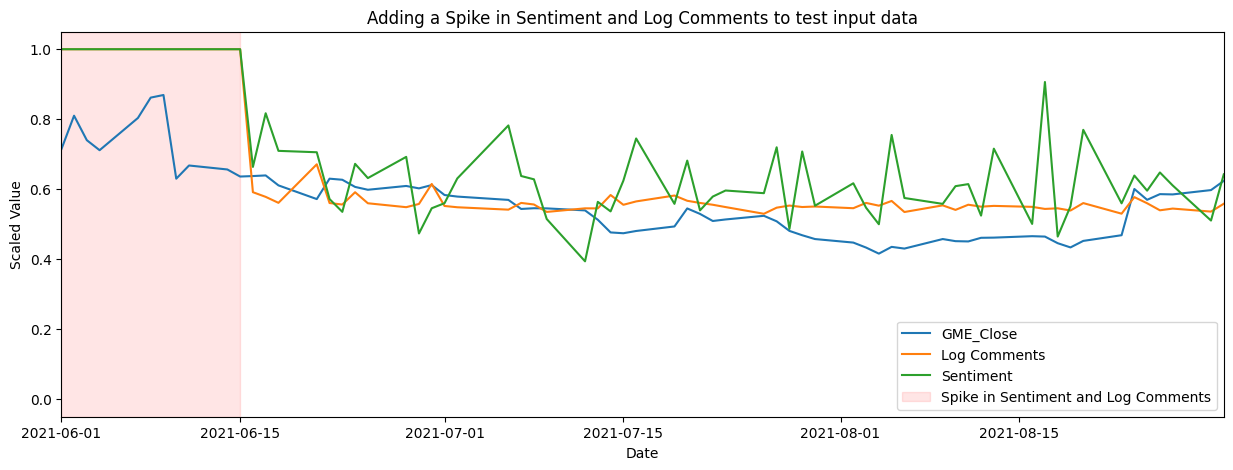

In [138]:
# Graph gme_close, log_comments and sentiment
plt.figure(figsize=(15, 5))
plt.plot(data_modified.index, data_modified['GME_Close'], label='GME_Close')
plt.plot(data_modified.index, data_modified['log_comments'], label='Log Comments')
plt.plot(data_modified.index, data_modified['sentiment'], label='Sentiment')
plt.title('Adding a Spike in Sentiment and Log Comments to test input data')

# x limit from 6/1 to 8/31
plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2021-08-31'))
# add translucent red box to show where the spike is
plt.axvspan(pd.Timestamp('2021-06-01'), pd.Timestamp('2021-06-15'), color='red', alpha=0.1, label='Spike in Sentiment and Log Comments')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()

## Create new data loader for modified test data

In [139]:
data_modified_vals = data_modified.values

# Create sequences
sequences_new = create_sequences(data_modified_vals, seq_length)

# Convert to PyTorch tensors
inputs_mod = torch.Tensor([seq for seq, _ in sequences_new])
labels_mod = torch.Tensor([label for _, label in sequences_new]).unsqueeze(1)  # Unsqueeze to add a singleton dimension

# Create new test dataset
test_dataset_modified = TensorDataset(inputs_mod[test_indices], labels_mod[test_indices])

# Create DataLoader for each set, setting pin=True and num_workers = 2
batch_size = 4
test_loader_modified = DataLoader(test_dataset_modified, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

## Feed modified data into LSTM model

In [140]:
model_new.eval()

# Get predictions on test data
pred_ts_mod = np.array([])

for i, (sequences, labels) in enumerate(test_loader_modified):  
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_new(sequences)
        
        # concat the predictions and actuals
        pred_ts_mod = np.concatenate([pred_ts_mod, outputs.cpu().numpy()[:, 0, 0].flatten() ])



## Plot modified test predictions with/without sentiment spike

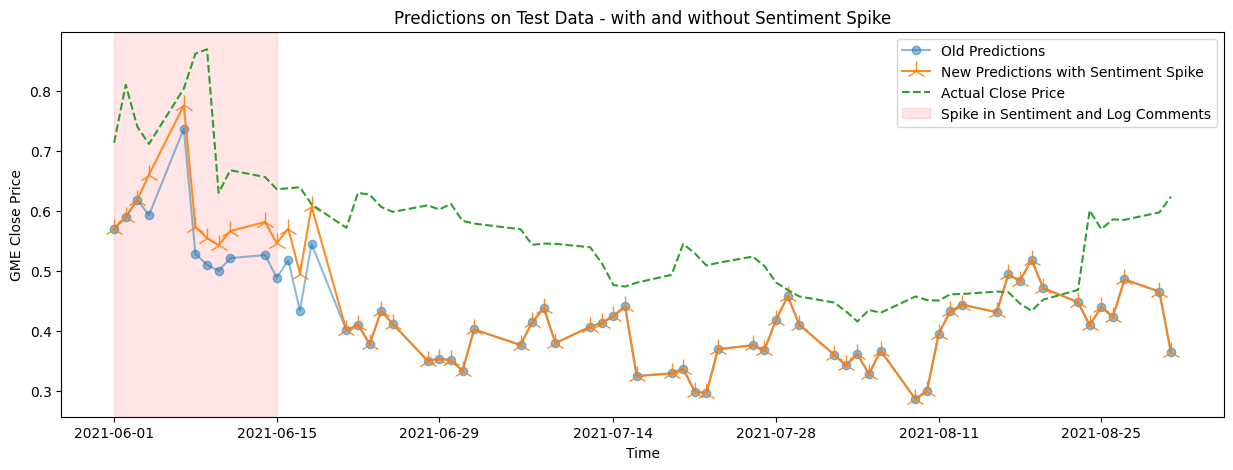

In [141]:
# Get dates for the test predictions
n_prediction_mod = len(pred_ts_mod)
n_prediction = len(pred_ts)

# Turn index into column called "Dates" for data_modified
dates_mod = data_modified.reset_index()['Date'][-n_prediction_mod:]
dates = data_transformed.reset_index()['Date'][-n_prediction:]

# Plot the data
plt.figure(figsize=(15, 5))
plt.plot(dates, pred_ts, label='Old Predictions', alpha = .5, marker='o')
plt.plot( dates_mod, pred_ts_mod, label='New Predictions with Sentiment Spike', marker = '2', alpha = .9, markersize = 15)
plt.plot( dates, actual_ts, label='Actual Close Price', linestyle='dashed')
plt.axvspan(pd.Timestamp('2021-06-01'), pd.Timestamp('2021-06-15'), color='red', alpha=0.1, label='Spike in Sentiment and Log Comments')

# Show x labels only every 10 days
plt.xticks(dates[::10])

plt.xlabel('Time')
plt.ylabel('GME Close Price')
plt.title('Predictions on Test Data - with and without Sentiment Spike')
plt.legend()
plt.show()